In [1]:
!pip install kaggle
!pip install numpy==1.19.2
!pip install catboost

     |████████████████████████████████| 14.5MB 206kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0


In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

In [5]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/kaggle/': No such file or directory


In [6]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/325k [00:00<?, ?B/s]
100% 325k/325k [00:00<00:00, 45.1MB/s]
  0% 0.00/324k [00:00<?, ?B/s]
100% 324k/324k [00:00<00:00, 45.0MB/s]
  0% 0.00/329k [00:00<?, ?B/s]
100% 329k/329k [00:00<00:00, 37.6MB/s]
  0% 0.00/315k [00:00<?, ?B/s]
100% 315k/315k [00:00<00:00, 97.7MB/s]
  0% 0.00/336k [00:00<?, ?B/s]
100% 336k/336k [00:00<00:00, 82.5MB/s]
  0% 0.00/324k [00:00<?, ?B/s]
100% 324k/324k [00:00<00:00, 103MB/s]
  0% 0.00/325k [00:00<?, ?B/s]
100% 325k/325k [00:00<00:00, 97.6MB/s]
  0% 0.00/332k [00:00<?, ?B/s]
100% 332k/332k [00:00<00:00, 104MB/s]
  0% 0.00/310k [00:00<?, ?B/s]
100% 310k/310k [00:00<00:00, 141MB/s]
  0% 0.00/360k [00:00<?, ?B/s]
100% 360k/360k [00:00<00:00, 117MB/s]
  0% 0.00/312k [00:00<?, ?B/s]
100% 312k/312k [00:00<00:00, 146MB/s]
  0% 0.00/321k [00:00<?, ?B/s]
100% 321k/321k [00:00<00:00, 98.0MB/s]
  0% 0.00/320k [00:00<?, ?B/s]
100% 320k/320k [00:00<00:00, 84.7MB/s]
  0% 0.00/319k [00:00<?, ?B/s]
100% 319k/319k [00:00<00:00, 42.2MB/s]
  0% 0.00/330k [00:00<?, 

In [7]:
!unzip train.csv.zip
!ls


Archive:  train.csv.zip
  inflating: train.csv               
sample_data	       seg_0042cc.csv  seg_006e4a.csv  seg_00e5f7.csv
sample_submission.csv  seg_004314.csv  seg_007a37.csv  seg_00f3b9.csv
seg_00030f.csv	       seg_004cd2.csv  seg_00a37e.csv  seg_010eab.csv
seg_0012b5.csv	       seg_004ee5.csv  seg_00be11.csv  seg_0125d9.csv
seg_00184e.csv	       seg_004f1f.csv  seg_00c35b.csv  train.csv
seg_003339.csv	       seg_00648a.csv  seg_00cc91.csv  train.csv.zip


In [8]:
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [9]:
train.head(10)

acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691
5              8           1.4691
6              9           1.4691
7              7           1.4691
8             -5           1.4691
9              3           1.4691

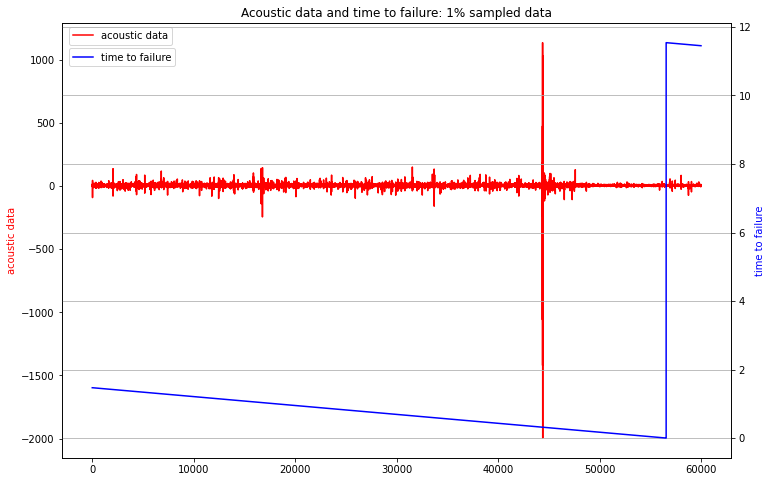

In [10]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df


In [11]:
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [ ]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [15]:
X_train.describe()



0           1            2   ...           10          11          12
count  380.000000  380.000000   380.000000  ...   380.000000  380.000000  380.000000
mean     4.512258    6.447230  -145.557895  ...   164.300000    5.498663    5.680177
std      0.193649   10.365899   313.099324  ...   329.410643    1.764578   10.188306
min      3.798020    3.045099 -4621.000000  ...    34.000000    4.471280    2.728451
25%      4.383545    4.188182  -139.000000  ...    88.000000    4.934063    3.685524
50%      4.509527    5.297148  -102.500000  ...   120.000000    5.298330    4.514285
75%      4.649685    6.437348   -75.000000  ...   162.250000    5.688635    5.505151
max      5.010620  142.976883   -27.000000  ...  4621.000000   28.832627  140.105751

[8 rows x 13 columns]

In [16]:
train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=1000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 0.8031854263141148}}